# Import Libraries

In [93]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Loading & examining data


In [84]:
# Load the customer_data
customer_data = pd.read_csv('/Users/kiranbele/Documents/Projects/Customer-Analytics-A-B-Testing/ab-testing-project/datasets/user_demographics_v1.csv')

# Load the app_purchases
app_purchases = pd.read_csv('/Users/kiranbele/Documents/Projects/Customer-Analytics-A-B-Testing/ab-testing-project/datasets/purchase_data_v1.csv')

# Print the columns of customer data
print(customer_data.columns)

# Print the columns of app_purchases
print(app_purchases.columns)

Index(['uid', 'reg_date', 'device', 'gender', 'country', 'age'], dtype='object')
Index(['date', 'uid', 'sku', 'price'], dtype='object')


# Merging on different sets of fields

In [85]:
# Merge on the 'uid' field
Purchase_data = app_purchases.merge(customer_data, on=['uid'], how='inner')

# Examine the results 
print(Purchase_data.head())
print(len(Purchase_data))

         date       uid            sku  price              reg_date device  \
0  2017-07-10  41195147  sku_three_499    499  2017-06-26T00:00:00Z    and   
1  2017-07-15  41195147  sku_three_499    499  2017-06-26T00:00:00Z    and   
2  2017-11-12  41195147   sku_four_599    599  2017-06-26T00:00:00Z    and   
3  2017-09-26  91591874    sku_two_299    299  2017-01-05T00:00:00Z    and   
4  2017-12-01  91591874   sku_four_599    599  2017-01-05T00:00:00Z    and   

  gender country  age  
0      M     BRA   17  
1      M     BRA   17  
2      M     BRA   17  
3      M     TUR   17  
4      M     TUR   17  
9006


# Aggregations

In [86]:

# Calculate the mean purchase price 
purchase_price_mean = Purchase_data.price.agg('mean')

# Examine the output 
print(purchase_price_mean)

406.77259604707973


In [87]:
# Calculate the mean and median purchase price 
purchase_price_summary = Purchase_data.price.agg(['mean', 'median'])

# Examine the output 
print(purchase_price_summary)

mean      406.772596
median    299.000000
Name: price, dtype: float64


In [88]:
# Calculate the mean and median of price and age
purchase_summary = Purchase_data.agg({'price': ['mean', 'median'], 'age': ['mean', 'median']})

# Examine the output 
print(purchase_summary)

             price        age
mean    406.772596  23.922274
median  299.000000  21.000000


# Grouping & aggregating

In [89]:
# Group the data 
grouped_purchase_data = Purchase_data.groupby(by=['device', 'gender'])

# Aggregate the data
purchase_summary = grouped_purchase_data.agg({'price': ['mean', 'median', 'std']})

# Examine the results
print(purchase_summary)

                    price                   
                     mean median         std
device gender                               
and    F       400.747504  299.0  179.984378
       M       416.237308  499.0  195.001520
iOS    F       404.435330  299.0  181.524952
       M       405.272401  299.0  196.843197


# Calculating KPIs

calculating the average amount paid per purchase within a user's first 28 days using the purchase_data DataFrame from before.

This KPI can provide a sense of the popularity of different in-app purchase price points to users within their first month.

In [97]:
Purchase_data['reg_date'] = pd.to_datetime(Purchase_data['reg_date'], errors='coerce')

# Define the current date
current_date = datetime.now()  # or use a specific date, e.g., datetime(2023, 10, 1)

# To Compute max_purchase_date
max_purchase_date = current_date - timedelta(days=28)

# Make 'reg_date' timezone-naive
Purchase_data['reg_date'] = Purchase_data['reg_date'].dt.tz_localize(None)

# Filter to only include users who registered before max_purchase_date
purchase_data_filt = Purchase_data[Purchase_data['reg_date'] < max_purchase_date]

# Filter to contain only purchases within the first 28 days of registration
purchase_data_filt = purchase_data_filt[(purchase_data_filt.date <= purchase_data_filt.reg_date + timedelta(days=28))]

# Output the mean price paid per purchase
print(purchase_data_filt.price.mean())

415.7741935483871


## Average purchase price by cohort

In [98]:
# Setting the max registration date to be one month before today
max_reg_date = current_date - timedelta(days=28)

# Finding the month 1 values
month1 = np.where((Purchase_data.reg_date < max_reg_date) & (Purchase_data.date < Purchase_data.reg_date + timedelta(days=28)), Purchase_data.price, np.nan)
                 
# Updating the value in the DataFrame
Purchase_data['month1'] = month1

# Grouping the data by gender and device 
purchase_data_upd = Purchase_data.groupby(by=['gender', 'device'], as_index=False)

# Aggregating the month1 and price data 
purchase_summary = purchase_data_upd.agg({'month1': ['mean', 'median'],'price': ['mean', 'median']})

# Examine the results 
print(purchase_summary)

  gender device      month1              price       
                       mean median        mean median
0      F    and  390.758242  299.0  400.747504  299.0
1      F    iOS  429.434783  499.0  404.435330  299.0
2      M    and  417.285714  499.0  416.237308  499.0
3      M    iOS  434.398230  499.0  405.272401  299.0


This value seems relatively stable over the past 28 days.

# Working with Time Series Data Using Pandas

# Parsing dates

In [64]:
# Paring of variety of date formats 
date_data_one = "Saturday, January 27, 2017"  
date_data_one = pd.to_datetime(date_data_one, format="%A, %B %d, %Y")  
print(date_data_one)
date_data_two = "2017-08-01"
date_data_two = pd.to_datetime(date_data_two, format="%Y-%m-%d")
print(date_data_two)
date_data_three = "08/17/1978"
date_data_three = pd.to_datetime(date_data_three, format="%m/%d/%Y")
print(date_data_three)
date_data_four = "2016 March 01 01:56"
date_data_four = pd.to_datetime(date_data_four, format="%Y %B %d %H:%M")
print(date_data_four)

2017-01-27 00:00:00
2017-08-01 00:00:00
1978-08-17 00:00:00
2016-03-01 01:56:00


# Plotting time series data

In [102]:
# Ensure 'date' and 'reg_date' are datetime objects
Purchase_data['date'] = pd.to_datetime(Purchase_data['date'], errors='coerce')
Purchase_data['reg_date'] = pd.to_datetime(Purchase_data['reg_date'], errors='coerce')

# Add a column to indicate first-week purchases (1 if within 7 days, else 0)
Purchase_data['first_week_purchases'] = (
    (Purchase_data['date'] >= Purchase_data['reg_date']) & 
    (Purchase_data['date'] <= Purchase_data['reg_date'] + pd.Timedelta(days=7))
).astype(int)

# Verify the column creation
print(Purchase_data.head())



        date       uid            sku  price   reg_date device gender country  \
0 2017-07-10  41195147  sku_three_499    499 2017-06-26    and      M     BRA   
1 2017-07-15  41195147  sku_three_499    499 2017-06-26    and      M     BRA   
2 2017-11-12  41195147   sku_four_599    599 2017-06-26    and      M     BRA   
3 2017-09-26  91591874    sku_two_299    299 2017-01-05    and      M     TUR   
4 2017-12-01  91591874   sku_four_599    599 2017-01-05    and      M     TUR   

   age  month1  first_week_purchases  
0   17   499.0                     0  
1   17   499.0                     0  
2   17     NaN                     0  
3   17     NaN                     0  
4   17     NaN                     0  


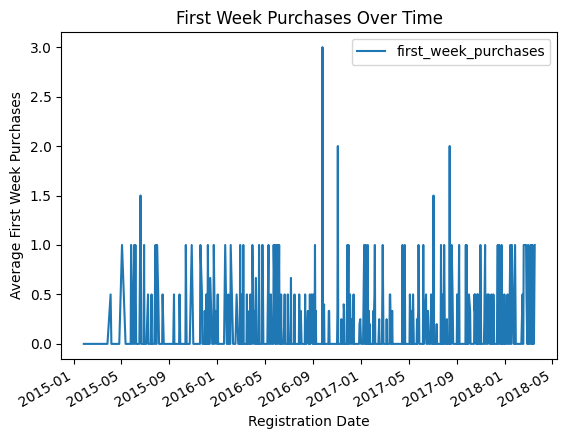

In [103]:
# Group the data and aggregate first_week_purchases
user_purchases = Purchase_data.groupby(by=['reg_date', 'uid']).agg({'first_week_purchases': ['sum']})

# Reset the indexes
user_purchases.columns = user_purchases.columns.droplevel(level=1)
user_purchases.reset_index(inplace=True)

# Find the average number of purchases per day by first-week users
user_purchases = user_purchases.groupby(by=['reg_date']).agg({'first_week_purchases': ['mean']})
user_purchases.columns = user_purchases.columns.droplevel(level=1)
user_purchases.reset_index(inplace=True)

# Plot the results 
user_purchases.plot(x='reg_date', y='first_week_purchases', kind='line', title='First Week Purchases Over Time')
plt.xlabel("Registration Date")
plt.ylabel("Average First Week Purchases")
plt.show()
